In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import clear_output
import copy

In [4]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Set data directories


In [5]:
data_dir = 'food-101'
imgs_dir = os.path.join(data_dir, 'images')
meta_dir = os.path.join(data_dir, 'meta')

# Read meta data

In [6]:
train_meta = pd.read_csv(os.path.join(meta_dir, 'train.txt'), delimiter='/', names=['target', 'image'])
test_meta = pd.read_csv(os.path.join(meta_dir, 'test.txt'), delimiter='/', names=['target', 'image'])
train_meta['train'] = 1
test_meta['train'] = 0

In [7]:
all_data = pd.concat([train_meta, test_meta])
targets = all_data['target']
all_data = pd.get_dummies(all_data, columns=['target'])
all_data['target'] = targets
print(all_data.head())

     image  train  target_apple_pie  target_baby_back_ribs  target_baklava  \
0  1005649      1                 1                      0               0   
1  1014775      1                 1                      0               0   
2  1026328      1                 1                      0               0   
3  1028787      1                 1                      0               0   
4  1043283      1                 1                      0               0   

   target_beef_carpaccio  target_beef_tartare  target_beet_salad  \
0                      0                    0                  0   
1                      0                    0                  0   
2                      0                    0                  0   
3                      0                    0                  0   
4                      0                    0                  0   

   target_beignets  target_bibimbap  ...  target_spring_rolls  target_steak  \
0                0                0  ...   

In [8]:
labels = [label[7:] for label in all_data.columns.values[2:103]]
print(labels)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [9]:
train_meta = all_data[all_data['train']==1]
test_meta = all_data[all_data['train']==0]
train_meta.drop('train', axis=1, inplace=True)
test_meta.drop('train', axis=1, inplace=True)
print(train_meta.head())
print(test_meta.head())

     image  target_apple_pie  target_baby_back_ribs  target_baklava  \
0  1005649                 1                      0               0   
1  1014775                 1                      0               0   
2  1026328                 1                      0               0   
3  1028787                 1                      0               0   
4  1043283                 1                      0               0   

   target_beef_carpaccio  target_beef_tartare  target_beet_salad  \
0                      0                    0                  0   
1                      0                    0                  0   
2                      0                    0                  0   
3                      0                    0                  0   
4                      0                    0                  0   

   target_beignets  target_bibimbap  target_bread_pudding  ...  \
0                0                0                     0  ...   
1                0              

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Analysis of training data

In [10]:
counts = train_meta.groupby('target')['image'].count()

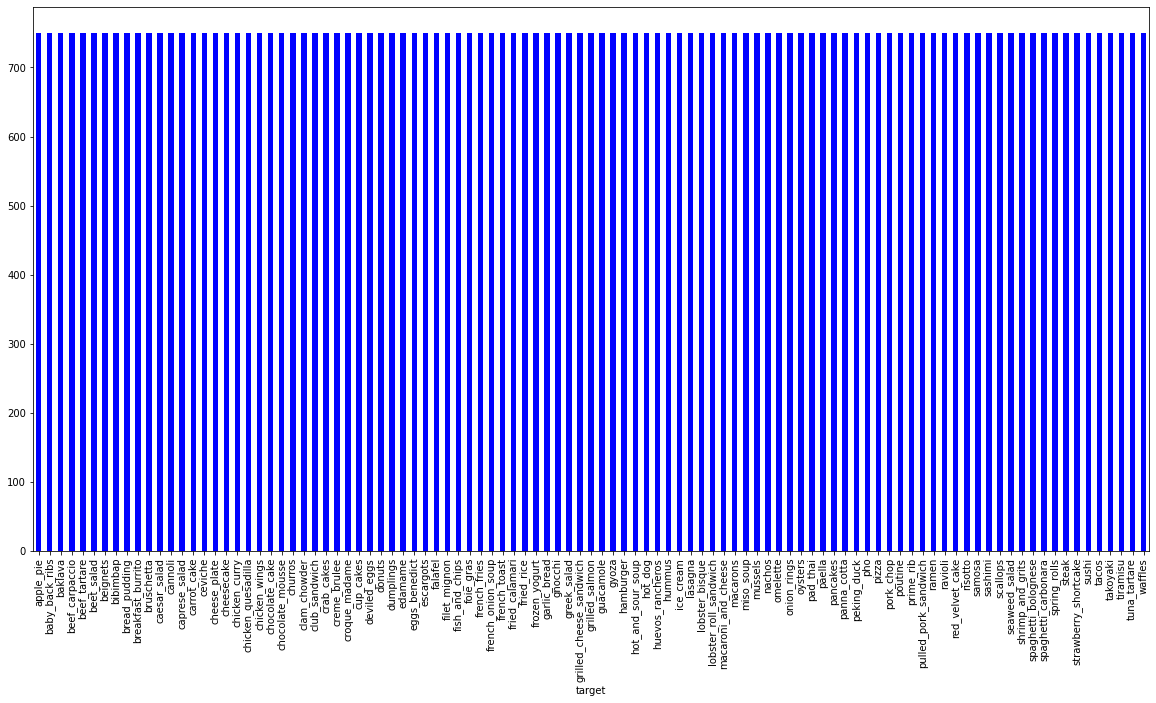

In [11]:
counts.plot(kind='bar', stacked='True', figsize=(20, 10), color='blue', legend=False);

The training data consists of 75750 images, 750 images each of 101 food categories. So the training set is perfectly balanced which should be good in terms of better training results.

# Data generator

In [12]:
import tensorflow as tf
import random

In [13]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

All the images, including both train and test images, are provided in seperate folders for each class and train and test meta data are provided as csv files. So we need to define a generator using ImageDataGenerator class of keras, which will select a random batch of images before performing the proper augmentations and feeding to the network for training.

In [14]:
# Declare an ImageDataGenerator object with proper image transformations and preprocessing.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=None,
            shear_range=0.2,
            zoom_range=0.2,
            channel_shift_range=0.0,
            fill_mode="nearest",
            horizontal_flip=True,
            vertical_flip=True,
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
# A generator with no augmentation (for testing)
image_generator_no_aug = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

In [15]:
def generator(df, batch_size=32, target_size=224, test=False):
    """
    Takes a train/test metadata DataFrame and yields a batch of (x, y) for training/testing.
    Usage:
    (x, y) = generator(df, batch_size, target_size)
    Inputs:
    df - train/test metadata (DataFrame)
    batch_size - batch size for train/test (int)
    target_size - target size for input image (int)
    Output:
    A batch of training/testing data of size [batch_size, target_size, target_size, 3] (float)
    """
    num_imgs = len(df) # Number of images in the train/test set
    while True:
        batch_rows = df.iloc[random.choices(range(0,num_imgs), k=batch_size)] # Select batch_size number of random
                                                                              # rows from the meta data
        x = []
        y = []
        for _,row in batch_rows.iterrows():
            file_name = row['target'] + '/' + str(row['image']) + '.jpg' # Image file name
            image = tf.keras.preprocessing.image.load_img(
                os.path.join(imgs_dir, file_name), 
                target_size=(target_size, target_size)
            )                                                            # Read image
            input_arr = tf.keras.preprocessing.image.img_to_array(image) # Convert image to array
            x.append(input_arr)                                          # Append image array to x
            y.append(row.iloc[1:102].values)                             # Append categorical label to y
        # Convert x and y to numpy arrays
        x = np.array(x, dtype=float)
        y = np.array(y, dtype=float)
        # Perform transformations
        if test:
            data_generator = image_generator_no_aug.flow(x, y, batch_size=batch_size)
        else:
            data_generator = image_generator.flow(x, y, batch_size=batch_size) 
        xt, yt = data_generator.next()
        # Yield outputs
        yield(np.array(xt), np.array(yt))


# Setting Parameters

In [16]:
batch_size = 16
img_size = 224
dropout = 0.5
num_imgs = len(train_meta)
num_val_imgs = len(test_meta)
steps = int(num_imgs/batch_size)
val_steps = int(num_val_imgs/batch_size)
model_file = 'resnet50_do_{}.h5'.format(dropout)
plt.rcParams["figure.figsize"] = (20, 10)

# Display a batch of training images
We shall display a single batch of train images and see how augementations are applied on the batch.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

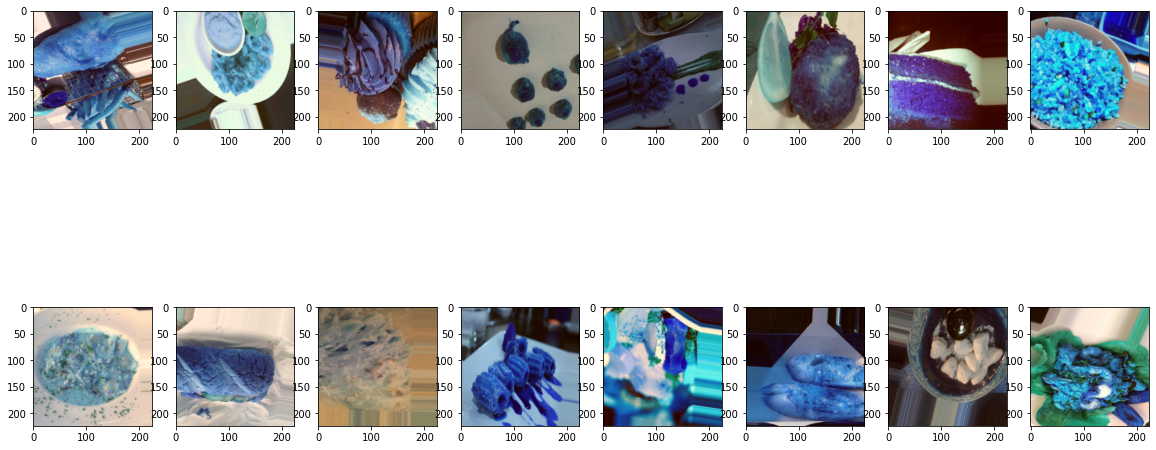

In [17]:
# For sub-plot
num_cols = 8 
num_rows = np.ceil(batch_size/num_cols)
# Declare train and test generators
train_generator = generator(train_meta, batch_size=batch_size, target_size=img_size)
test_generator = generator(test_meta, batch_size=batch_size, target_size=img_size, test=True)

x, y = next(train_generator) # Get a single batch of train data
# Plot all the images in the batch
for i in range(0, batch_size):
    img = x[i,:,:,:]
    # Inverse preprocessing
    img[:,:,2] += 103.939
    img[:,:,1] += 116.779
    img[:,:,0] += 123.68
    # Plot
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(img/255)

# Building the model
Base model from resnet50 pretrained on imagenet dataset.

In [18]:
def get_model():
    """
    Returns the network model.
    The base model is ResNet50 trained on imagenet dataset.
    The classifier contains 3 FC layers with 4096, 4096 and 101 nuerons respectively.
    """
    base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
    #for layer in base_model.layers:
    #layer.trainable = False
    #base_model.summary()
    features = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(101, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
    return model

# Defining callbacks

Keras callbacks enables to writes routines that could be called at specific time points in the middle of the training process. Callbacks could be used to output intermediate information during training and to make sure that the training process is heading in the right direction among other things. The following callback class tries to combine some of the best practises so that the training process goes on smoothly.

In [53]:
class TheCallback(tf.keras.callbacks.Callback):
    """
    A single callback class that combines all the best practises.
    1. Evaluates the validation loss and accuracy at the end of every epoch.
    2. Live plot of training curves (both loss and accuracy) updated after every epoch.
    3. Learning rate reduction on loss plateau.
    4. Saves best model to file.
    """
    def __init__(self, val_generator, val_steps, patience=5, lr_factor=0.1, model_file='model.h5'):
        self.val_generator = val_generator
        self.patience = patience
        self.best = np.Inf
        self.lr_factor = lr_factor
        self.model_file = model_file
        self.val_steps = val_steps
        
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.wait = 0
        self.best_weights = None
        print('Begin training with lr = {}'.format(self.model.optimizer.lr.numpy))
        
    def on_epoch_end(self, epoch, logs={}):
        
        # Append training loss and accuracy
        self.losses.append(logs['loss'])
        self.acc.append(logs['acc'])
        
        # Evaluate model
        model = self.model
        metrics = model.evaluate(
            self.val_generator, 
            steps=self.val_steps, 
            return_dict=True
        )
        
        # Append validation loss and accuracy
        self.val_losses.append(metrics['loss'])
        self.val_acc.append(metrics['acc'])
        
        # Plot learning curves
        plt.subplot(1,2,1)
        plt.plot(self.losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(self.acc, label='Train Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        clear_output(wait=True)
        plt.show()
        
        # Rate reduction on plateau
        if self.val_losses[-1] < self.best:
            self.best = self.val_losses[-1]
            self.model.save(self.model_file) # Save the best model to file
            print('Saving model to {} at epoch: {}.' 
                  'Validation Loss: {}. Validation Accuracy: {}'
                  .format(self.model_file, epoch, self.val_losses[-1], self.val_acc[-1])
                 )
            self.wait = 0
        else:
            self.wait += 1
            # If ran out of patience reduce lr
            if self.wait >= self.patience:
                lr = tf.keras.backend.get_value(self.model.optimizer.lr) # Current lr
                tf.keras.backend.set_value(self.model.optimizer.lr, lr*self.lr_factor) # Reduce lr by lr_factor
                print('Reducing lr from {} to {}'.format(lr, lr*self.lr_factor))
            
        

# Learning Rate finder

Learning rate is a very important hyper parameter for deep learning training. If the learning rate is too high then the loss function could oscillate to and fro across the minima instead of converging at the minima. If the rate is low the model won't learn quick enough and would take ever to converge. So we try to find the best initial learning rate suited for our model and the data set. We progressively increase the learning rate after each epoch and plot the resulting loss curve and the derivative of the loss. The learning rate that gives the minimum derivative value is the best learning rate.

In [19]:
def learn_rate_finder(model, start_lr=1e-6, end_lr=1, epochs=1, steps=1):
    """
    Automatically find the optimum learning rate for training.
    """
    class LearnRateFinder(tf.keras.callbacks.Callback):
        """
        
        """
        def __init__(self, lr_factor):
            self.lr_factor = lr_factor 
            
        def on_train_begin(self, logs={}):
            self.losses = []
            self.lrs = []
            self.batch_num = 1
            
        def on_batch_end(self, epoch, logs={}):
            self.batch_num += 1
            self.lrs.append(tf.keras.backend.get_value(self.model.optimizer.lr))
            self.losses.append(logs['loss'])
            tf.keras.backend.set_value(self.model.optimizer.lr, self.lrs[-1] * self.lr_factor)
            
        def get_best_lr_exp_weighted(self, beta=0.98, n_skip_beginning=10, n_skip_end=5):
            derivatives = self.exp_weighted_derivatives(beta)
            return min(zip(derivatives[n_skip_beginning:-n_skip_end], self.lrs[n_skip_beginning:-n_skip_end]))[1]

        def exp_weighted_losses(self, beta=0.98):
            losses = []
            avg_loss = 0.
            for batch_num, loss in enumerate(self.losses):
                avg_loss = beta * avg_loss + (1 - beta) * loss
                smoothed_loss = avg_loss / (1 - beta ** (batch_num+1))
                losses.append(smoothed_loss)
            return losses

        def exp_weighted_derivatives(self, beta=0.98):
            derivatives = [0]
            losses = self.exp_weighted_losses(beta)
            for i in range(1, len(losses)):
                derivatives.append((losses[i] - losses[i - 1]) / 1)
            return derivatives
                
        def on_train_end(self, logs={}):
            loss_derivatives = self.exp_weighted_derivatives()
            plt.plot(self.lrs, loss_derivatives, label='Derivative')
            plt.plot(self.lrs, self.losses, label='loss')
            plt.xscale('log')
            plt.legend()
            print('The best lr is {}.'.format(self.get_best_lr_exp_weighted()))
            
    lr_factor = (float(end_lr) / float(start_lr)) ** (1. / float(steps * epochs))
    callback = LearnRateFinder(lr_factor)
    opt = tf.keras.optimizers.Adam(lr=start_lr)
    model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=opt)
    model.fit(train_generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[callback])

94773248/94765736 [==============================] - 13s 0us/step
Epoch 1/10
100/100 [==============================] - 74s 736ms/step - loss: 4.7843 - acc: 0.0075
Epoch 2/10
100/100 [==============================] - 66s 659ms/step - loss: 4.7360 - acc: 0.0144
Epoch 3/10
100/100 [==============================] - 60s 601ms/step - loss: 4.6241 - acc: 0.0213
Epoch 4/10
100/100 [==============================] - 56s 560ms/step - loss: 4.3414 - acc: 0.0712
Epoch 5/10
100/100 [==============================] - 52s 519ms/step - loss: 4.0760 - acc: 0.1206
Epoch 6/10
100/100 [==============================] - 49s 491ms/step - loss: 4.2141 - acc: 0.1031
Epoch 7/10
100/100 [==============================] - 47s 469ms/step - loss: 4.4823 - acc: 0.0375
Epoch 8/10
100/100 [==============================] - 45s 454ms/step - loss: 4.6786 - acc: 0.0075
Epoch 9/10
100/100 [==============================] - 44s 439ms/step - loss: 4.9975 - acc: 0.0056
Epoch 10/10
100/100 [==============================]

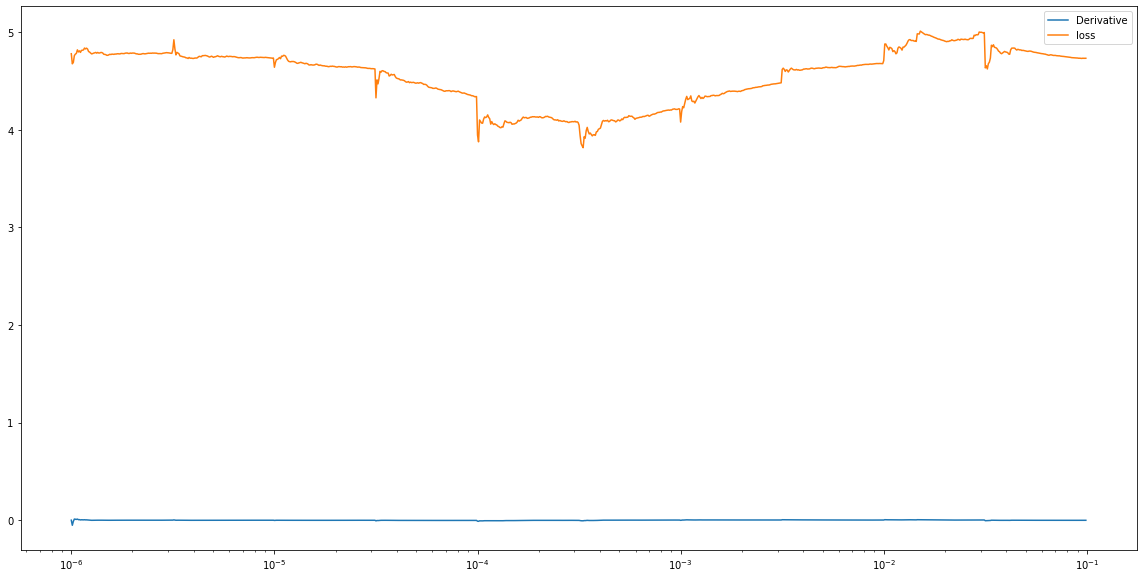

In [20]:
# Run learning rate finder
epochs = 10
lrf_steps = 100
model = get_model()
learn_rate_finder(model, start_lr=1e-6, end_lr=0.1, epochs=epochs, steps=lrf_steps)

# Run the model

In [54]:
model = get_model()
#model = tf.keras.models.load_model('resnet50_do0.2.h5')
model.summary()
opt = tf.keras.optimizers.Adam(lr=1e-4) # Set initial lr = best lr
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=opt)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [55]:
# Declare the callback
callback = TheCallback(test_generator, val_steps, patience=2, lr_factor=0.5, model_file=model_file)

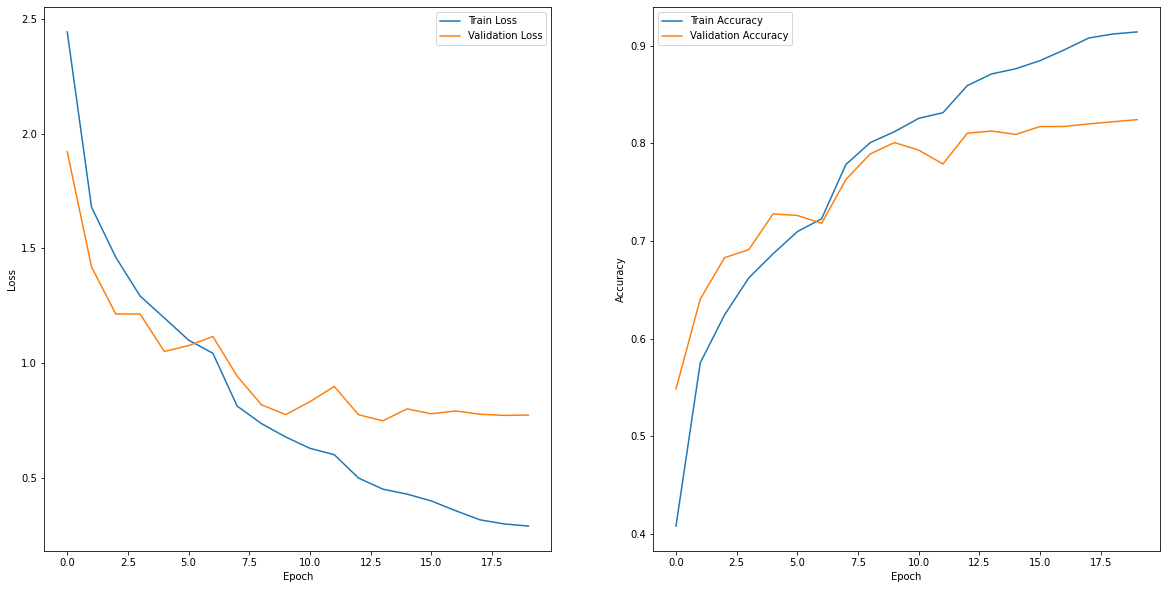

Reducing lr from 1.56249996052793e-06 to 7.81249980263965e-07
4734/4734 [==============================] - 1277s 270ms/step - loss: 0.2882 - acc: 0.9140


In [56]:
# Run the model
history = model.fit_generator(train_generator, epochs=20, steps_per_epoch=steps, verbose=1, callbacks=[callback])

After 20 epochs of training we get a training accuracy of 91.40% and test accuracy of around 82.5%.

# Test set evaluation
Besides the normal test set evaluation we also do a multi-crop testing to see if it can give any improvements.

In [24]:
model = tf.keras.models.load_model(model_file)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [57]:
x = []
y = []
true_count = 0 # Count of correctly classified
total_count = 0 # Total count of images tested
acc = 0 # Accuracy
# Run through all the test images
for _,row in test_meta.iterrows():
    file_name = row['target'] + '/' + str(row['image']) + '.jpg' # Test image file name
    image = tf.keras.preprocessing.image.load_img(
        os.path.join(imgs_dir, file_name), 
        target_size=(img_size, img_size)
    )                                                            # Load test image
    x = tf.keras.applications.resnet50.preprocess_input(
        tf.keras.preprocessing.image.img_to_array(image)
    ) # Apply pre-processing
    x = np.expand_dims(x, axis=0) # [224, 224, 3] => [1, 224, 224, 3]
    
    pred = model.predict(x) # Get probablities
    y.append(labels[np.argmax(pred)]) # Append class with max probablity to list of outputs
    # If prediction is correct increment true count
    if y[-1] == row['target']:
        true_count += 1
    total_count += 1
    acc = true_count * 100 / total_count # Calculate accuracy
    clear_output(wait=True)
    print('Tested {} images. Accuracy = {}'.format(total_count, acc))
clear_output(wait=True)
print('Test accuracy = {}'.format(acc))   

Test accuracy = 82.56633663366337


Test set accuracy is 82.56% which not bad but with training accuracy of 91.4%, there is still room for improvement with better regularization.

# Multi-crop testing
Multi-crop testing is a possible way to improve testing accuracy. Instead of testing each image once, in multi-crop testing we test multiple random crops of each image and average the probablities to make a guess. Here we would be taking 10 random crops of each test image.

In [26]:
def random_crop_image(img, crop_size=224, crop_percent=75):
    """
    Returns a random crop of the input image. The crop will contain crop_percent% of the input and will be
    resized to [crop_size, crop_size, 3] before returning.
    Usage:
    random_crop_image(img, crop_size, crop_percent)
    Inputs:
    img - Input image
    crop_size - The required output size. Default is 224.
    crop_percent - Percent part of the input required in the output. Default is 75.
    """ 
    width, height = img.size # Size of input
    # Size of cropped image
    cut_size_x = int(width * crop_percent/100)
    cut_size_y = int(height * crop_percent/100)
    # Randomly select starting point
    start_y = np.random.randint(0, height - cut_size_y)
    start_x = np.random.randint(0, width - cut_size_x)
    # Crop and resize
    crop = img.crop(box=(start_x, start_y, start_x + cut_size_x, start_y + cut_size_y))
    crop = crop.resize((crop_size, crop_size))
    return crop

In [58]:
x = []
y = []
num_crops = 10
true_count = 0 # Count of correctly classified
total_count = 0 # Total count of images tested
acc = 0 # Accuracy
# Run through all the test images
for _,row in test_meta.iterrows():
    x = np.zeros((num_crops, img_size, img_size, 3))
    file_name = row['target'] + '/' + str(row['image']) + '.jpg' # Image file name
    image = tf.keras.preprocessing.image.load_img(
        os.path.join(imgs_dir, file_name), 
        target_size=(img_size, img_size)
    )                                                            # Read image
    # Take 10 random crops of each image
    for i in range(0, num_crops):
        x[i, :, :, :] = tf.keras.applications.resnet50.preprocess_input(
            tf.keras.preprocessing.image.img_to_array(
                random_crop_image(image, crop_percent=90)
            )
        )
    pred = model.predict(x) # Make predicition on all 10 crops
    y.append(labels[np.argmax(np.sum(pred, axis=0))]) # Take average and append to y
    # If prediction is correct increment true count
    if y[-1] == row['target']:
        true_count += 1
    total_count += 1
    acc = true_count * 100 / total_count # Calculate accuracy
    clear_output(wait=True)
    print('Tested {} images. Accuracy = {}'.format(total_count, acc))
clear_output(wait=True)
print('Test accuracy = {}'.format(acc))   

Test accuracy = 85.17227722772277


Test accuracy improved by 2.6% with multi-crop testing. Impressive!!!

# Way forward
Possible ways to improve accuracy:
1. Test time augmentation.
2. Weigt decay and gradient clipping for better regularization.
3. Increasing input image size for latter epochs.